In [1]:
import numpy as np
import operator
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import os
from prettytable import PrettyTable
import math
import csv

import random
import folium
from folium.plugins import MarkerCluster
import pandas_profiling
import missingno as msno
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.distance import great_circle
import json
import vincent
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values and vice versa
from selenium import webdriver
import time

%matplotlib inline
vincent.core.initialize_notebook()

References
https://towardsdatascience.com/using-python-to-create-a-world-map-from-a-list-of-country-names-cd7480d03b10

https://www.kaggle.com/dabaker/fancy-folium

https://www.analyticsvidhya.com/blog/2020/06/guide-geospatial-analysis-folium-python/

https://insights.stackoverflow.com/survey

# manage raw data from csv files

In [2]:
current_wd = os.getcwd()

In [3]:
class RawDataManager:
    def __init__(self):
        self.__root_dir = current_wd + '/stack-overflow-raw-data-files-1/'
        self.__columns = ['Country', 'DevType', 'DatabaseDesireNextYear',
                          'DatabaseWorkedWith', 'EdLevel', 'Employment', 'Gender',
                          'JobSat', 'JobSeek',
                          'LanguageDesireNextYear', 'LanguageWorkedWith', 'OrgSize',
                          'SOComm', 'UndergradMajor']

        self.__survey_results_files_dict = {'2017':'survey_results_public_aligned.csv',
                                          '2018':'survey_results_public_aligned.csv',
                                          '2019':'survey_results_public.csv',
                                          '2020':'survey_results_public.csv'}
            
        self.years_under_analysis = self.__survey_results_files_dict.keys()

        self.df_concat = None

    def read_csv_files(self, file_names_list=None):
        missing_values_type_list = ["--", "", " ", "?", "None", "-", "NONE",
                                    "none", "inf", "INF", "-999","Inf"]
        if file_names_list == None:
            file_names_list = self.__survey_results_files_dict.keys()
            
        df_store_dict_loc = dict()
        
        for key in file_names_list: #self.__survey_results_files_dict.keys():
            survey_file_path = self.__root_dir + key + '/' + self.__survey_results_files_dict[key]
            df = pd.read_csv(survey_file_path, skipinitialspace=True,
                             usecols=self.__columns, low_memory=False, 
                             na_values=missing_values_type_list)

            df['Year'] = key
            df_store_dict_loc[key] = self.__set_job_satisfaction_index(key, df)
        self.df_concat = pd.concat(df_store_dict_loc, keys=df_store_dict_loc.keys()) # ignore_index=True: not needed here

    def __set_job_satisfaction_index(self, year, df_in):
        if year == '2017':
            return df_in
        elif year == '2018':
            df_in.replace(to_replace = 'Extremely dissatisfied', value=1, inplace=True)
            df_in.replace(to_replace = 'Moderately dissatisfied', value=2, inplace=True)
            df_in.replace(to_replace = 'Slightly dissatisfied', value=3, inplace=True)
            df_in.replace(to_replace = 'Neither satisfied nor dissatisfied', value=4, inplace=True)
            df_in.replace(to_replace = 'Slightly satisfied', value=5, inplace=True)
            df_in.replace(to_replace = 'Moderately satisfied', value=6, inplace=True)
            df_in.replace(to_replace = 'Extremely satisfied', value=7, inplace=True)
            return df_in
        elif year == '2019' or year == '2020':
            df_in.replace(to_replace = 'Very dissatisfied', value=1, inplace=True)
            df_in.replace(to_replace = 'Slightly dissatisfied', value=2, inplace=True)
            df_in.replace(to_replace = 'Neither satisfied nor dissatisfied', value=3, inplace=True)
            df_in.replace(to_replace = 'Slightly satisfied', value=4, inplace=True)
            df_in.replace(to_replace = 'Very satisfied', value=5, inplace=True)
            return df_in

    def get_country_locations_data_from_csv_files(self):
        file_path = current_wd + '/countries_locations.csv'
        return pd.read_csv(file_path)

    def get_df_for_selected_years(self, selected_years_list):
        df_store_dict_loc = dict()
        for year in selected_years_list:
            if len(selected_years_list) == 1:
                return self.df_concat.loc[year]
            else:
                df_store_dict_loc[year] = self.df_concat.loc[year]
        return pd.concat(df_store_dict_loc, \
                         keys=df_store_dict_loc.keys()) 

In [4]:
rawDataManager = RawDataManager()

In [5]:
rawDataManager.read_csv_files()

In [6]:
rawDataManager.df_concat.head(20)

Country                                         Employment  \
2017 0    United States             Not employed, and not looking for work   
     1   United Kingdom                                 Employed part-time   
     2   United Kingdom                                 Employed full-time   
     3    United States                                 Employed full-time   
     4      Switzerland                                 Employed full-time   
     5      New Zealand             Not employed, and not looking for work   
     6    United States                                 Employed full-time   
     7           Poland                                 Employed full-time   
     8         Colombia                                 Employed full-time   
     9           France  Independent contractor, freelancer, or self-em...   
     10   United States                                 Employed full-time   
     11          Canada                                 Employed full-time   
     12  United Kingdom                 Not employed, but looking for work   
     13         Germany                                 Employed full-time   
     14  United Kingdom                                 Employed full-time   
     15   United States  Independent contractor, freelancer, or self-em...   
     16  United Kingdom             Not employed, and not looking for work   
     17   United States                                 Employed full-time   
     18   United States                                 Employed full-time   
     19          Greece                                 Employed full-time   

                                                   EdLevel  \
2017 0                                    Secondary school   
     1   Some college/university study without earning ...   
     2                                   Bachelor's degree   
     3                                     Doctoral degree   
     4                                     Master's degree   
     5                                    Secondary school   
     6                                     Master's degree   
     7                                     Master's degree   
     8                                   Bachelor's degree   
     9                                     Master's degree   
     10                                  Bachelor's degree   
     11                                  Bachelor's degree   
     12                                  Bachelor's degree   
     13  Some college/university study without earning ...   
     14                                Professional degree   
     15                          Primary/elementary school   
     16                                   Secondary school   
     17                                  Bachelor's degree   
     18                                  Bachelor's degree   
     19                                    Doctoral degree   

                                            UndergradMajor  \
2017 0                                                 NaN   
     1            Computer science or software engineering   
     2            Computer science or software engineering   
     3       A non-computer-focused engineering discipline   
     4            Computer science or software engineering   
     5                                                 NaN   
     6       A non-computer-focused engineering discipline   
     7            Computer science or software engineering   
     8            Computer science or software engineering   
     9            Computer science or software engineering   
     10                                   A social science   
     11           Computer science or software engineering   
     12                          Mathematics or statistics   
     13           Computer science or software engineering   
     14  Computer engineering or electrical/electronics...   
     15                                                NaN   
     16             

In [7]:
rawDataManager.df_concat.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 303591 entries, ('2017', 0) to ('2020', 64460)
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Country                 302658 non-null  object 
 1   Employment              297748 non-null  object 
 2   EdLevel                 289916 non-null  object 
 3   UndergradMajor          248486 non-null  object 
 4   OrgSize                 226578 non-null  object 
 5   DevType                 258928 non-null  object 
 6   JobSat                  225834 non-null  float64
 7   JobSeek                 245150 non-null  object 
 8   LanguageWorkedWith      259906 non-null  object 
 9   LanguageDesireNextYear  245216 non-null  object 
 10  DatabaseWorkedWith      221285 non-null  object 
 11  DatabaseDesireNextYear  195824 non-null  object 
 12  SOComm                  253024 non-null  object 
 13  Gender                  235479 non-null  object 
 14  Y

In [8]:
# explore the data for each year from the concatenated dataframe
years_df_dict = dict()
for year in rawDataManager.years_under_analysis:
    print('Year = ', year)
    df_loc = rawDataManager.df_concat.loc[year]
    years_df_dict[year] = df_loc
    df_loc.info()

Year =  2017
<class 'pandas.core.frame.DataFrame'>
Int64Index: 51392 entries, 0 to 51391
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 51392 non-null  object 
 1   Employment              51392 non-null  object 
 2   EdLevel                 51392 non-null  object 
 3   UndergradMajor          42841 non-null  object 
 4   OrgSize                 38922 non-null  object 
 5   DevType                 36125 non-null  object 
 6   JobSat                  40376 non-null  float64
 7   JobSeek                 33380 non-null  object 
 8   LanguageWorkedWith      36625 non-null  object 
 9   LanguageDesireNextYear  33771 non-null  object 
 10  DatabaseWorkedWith      29452 non-null  object 
 11  DatabaseDesireNextYear  25109 non-null  object 
 12  SOComm                  32410 non-null  object 
 13  Gender                  35047 non-null  object 
 14  Year                    5

# missing values

In [9]:
df_2017 = years_df_dict['2017']

In [10]:
df_2017_null_count = df_2017.isnull().sum()

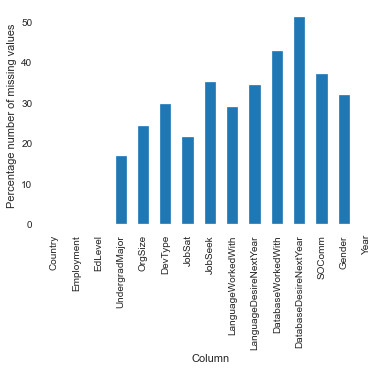

In [11]:
df_2017_null_count_percent = 100.0 * df_2017_null_count / len(df_2017)
df_2017_null_count_percent.plot.bar(x=df_2017_null_count_percent.index, y=df_2017_null_count_percent.values)
plt.ylabel('Percentage number of missing values')
plt.xlabel('Column')
plt.show()

In [12]:
df_2018 = years_df_dict['2018']

In [13]:
df_2018_null_count = df_2018.isnull().sum()

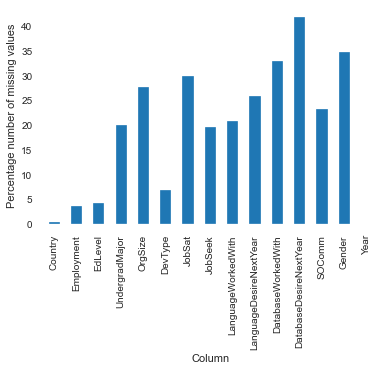

In [14]:
df_2018_null_count_percent = 100.0 * df_2018_null_count / len(df_2018)
df_2018_null_count_percent.plot.bar(x=df_2018_null_count_percent.index, y=df_2018_null_count_percent.values)
plt.ylabel('Percentage number of missing values')
plt.xlabel('Column')
plt.show()

In [15]:
df_2019 = years_df_dict['2019']

In [16]:
df_2019_null_count = df_2019.isnull().sum()

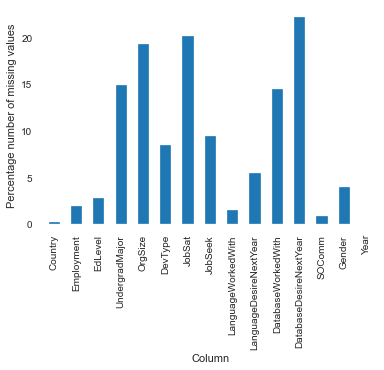

In [17]:
df_2019_null_count_percent = 100.0 * df_2019_null_count / len(df_2019)
df_2019_null_count_percent.plot.bar(x=df_2019_null_count_percent.index, y=df_2019_null_count_percent.values)
plt.ylabel('Percentage number of missing values')
plt.xlabel('Column')
plt.show()

In [18]:
df_2020 = years_df_dict['2020']

In [19]:
df_2020_null_count = df_2020.isnull().sum()

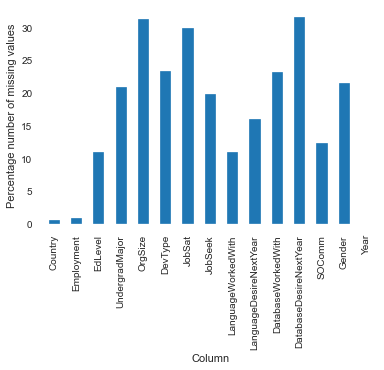

In [20]:
df_2020_null_count_percent = 100.0 * df_2020_null_count / len(df_2020)
df_2020_null_count_percent.plot.bar(x=df_2020_null_count_percent.index, y=df_2020_null_count_percent.values)
plt.ylabel('Percentage number of missing values')
plt.xlabel('Column')
plt.show()

# example missing values correlation heat map for df_2020

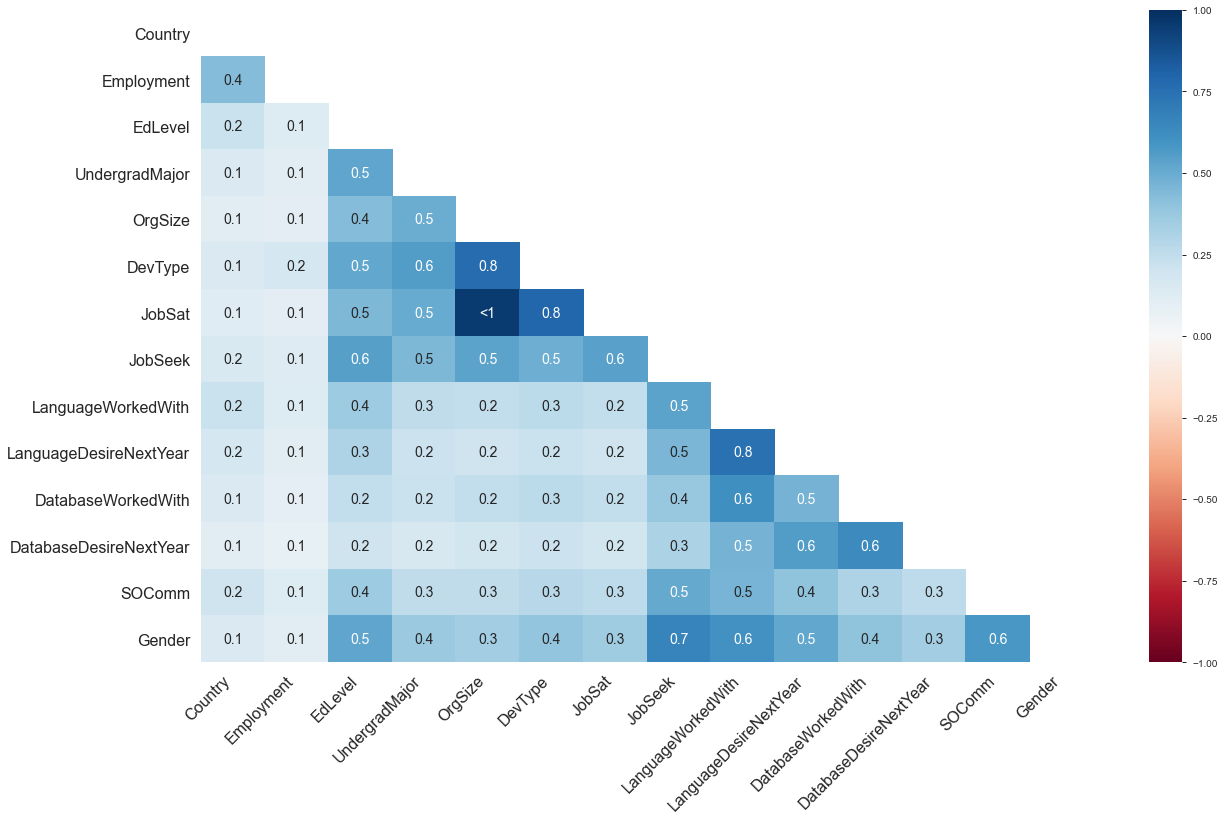

In [21]:
msno.heatmap(df_2020)
plt.show()

# Classes for managing the analysis of data

In [22]:
#Counter substrings in a delimited list of strings in the survey
class SubstringCounter:
    def __init__(self, delimiter=';', string_in=''):
        if string_in != None and len(string_in) > 0:
            self.__sub_strings = string_in.split(delimiter)
        else:
            self.__sub_strings = ''
    
    def set_sub_strings(self, string_in, delimiter=';'):
        if string_in != None and len(string_in) > 0:
            self.__sub_strings = string_in.split(delimiter)
        else:
            self.__sub_strings = ''
    
    def count_sub_strings(self, counts_dict):
        if  len(self.__sub_strings) > 0:
            for sub_string in self.__sub_strings:
                if sub_string != 'nan':
                    cnt = 0
                    sub_string_loc = sub_string.strip()
                    if not bool(counts_dict):
                        counts_dict[sub_string_loc] = cnt + 1
                    else:
                        if sub_string_loc in counts_dict.keys():
                            cnt = counts_dict[sub_string_loc] + 1
                            counts_dict.pop(sub_string_loc)
                            counts_dict[sub_string_loc] = cnt
                        else:
                            counts_dict[sub_string_loc] = cnt + 1

In [23]:
# Rank strings by number of counts in the survey
class LanguageRanking:
    def __init__(self, n=3): # n = 3 => first 3 top language rankings
        self.__rankings = dict()
        self.__blank = dict()
        self.__rankings_as_percent = dict()
        self.__rankings_as_percent_by_language = dict()
        self.__substringCounter =  SubstringCounter()
        self.__n_top_languages = n
     
    def set_number_of_top_languages_for_display(self, n):
        self.__n_top_languages = n
        
    def get_first_sorted_n_rankings(self, year, n_elements):
        lang_dict = self.__rankings[year]
        sorted_rankings = dict(sorted(lang_dict.items(), key=operator.itemgetter(1),reverse=True))
        return dict(itertools.islice(sorted_rankings.items(), n_elements))
        
    def get_first_sorted_n_percentage_rankings(self, year, n_elements):
        lang_dict = self.__rankings_as_percent[year]
        sorted_rankings = dict(sorted(lang_dict.items(), key=operator.itemgetter(1),reverse=True))
        return dict(itertools.islice(sorted_rankings.items(), n_elements))
    
    def get_first_sorted_n_rankings_by_languages(self):
        return self.__rankings_as_percent_by_language
    
    def __set_first_sorted_n_languages(self, year, dict_in, total_score):
        if bool(dict_in):
            sorted_rankings = dict(sorted(dict_in.items(), key=operator.itemgetter(1),reverse=True))
            n_elements_dict = dict(itertools.islice(sorted_rankings.items(), self.__n_top_languages))
            for language in n_elements_dict.keys():
                if bool(self.__rankings_as_percent_by_language):
                    if language in self.__rankings_as_percent_by_language.keys():
                        lang_by_year = self.__rankings_as_percent_by_language[language]
                        if year not in lang_by_year.keys():
                            lang_by_year[year] = round(100.0 * n_elements_dict[language] / total_score, 2)
                            self.__rankings_as_percent_by_language.pop(language)
                            self.__rankings_as_percent_by_language[language] = lang_by_year
                    else:
                        lang_by_year = dict()
                        lang_by_year[year] = round(100.0 * n_elements_dict[language] / total_score, 2)
                        self.__rankings_as_percent_by_language[language] = lang_by_year
                else:
                    lang_by_year = dict()
                    lang_by_year[year] = round(100.0 * n_elements_dict[language] / total_score, 2)
                    self.__rankings_as_percent_by_language[language] = lang_by_year
    
    def get_ranking(self):
        return self.__rankings
    
    def __check_key_in_dictionary(self, data_dict, key_token):
        if not bool(data_dict):
            return False
        else:
            if key_token in  data_dict.keys():
                return True
            else:
                return False
    
    def __set_blank_counts(self, year, df_in):
        if self.__check_key_in_dictionary(self.__blank, year) == False:
            blank_counts_srs = df_in.isnull().sum()
            self.__blank[year] =  blank_counts_srs['LanguageWorkedWith']
    
    def get_blank_rankings(self):
        return self.__blank
    
    def get_rankings_as_percentage(self):
        return self.__rankings_as_percent
    
    def __set_rankings_as_percent(self, lang_dict_in, year, total_score):
        if bool(lang_dict_in):
            lang_dict = dict()
            for language in lang_dict_in.keys():
                score = lang_dict_in[language]
                percentage_score = 100.0 * score / total_score
                lang_dict[language] = round(percentage_score, 2)
            self.__rankings_as_percent[year] = lang_dict
            
    def set_rankings(self,  df_in, year):
        languageWorkedWith_srs = df_in['LanguageWorkedWith']
        
        lang_dict = dict()
        for languageWorkedWith in  languageWorkedWith_srs.values:
            languageWorkedWith_loc = str(languageWorkedWith)
            self.__substringCounter.set_sub_strings(languageWorkedWith_loc)
            self.__substringCounter.count_sub_strings(lang_dict)
        self.__rankings[year] = lang_dict
        self.__set_blank_counts(year, df_in)
        
        blank_counts_srs = df_in.isnull().sum()
        blanks_score =  blank_counts_srs['LanguageWorkedWith']
        self.__set_rankings_as_percent(lang_dict, year, float(len(df_in) - blanks_score))
        self.__set_first_sorted_n_languages(year, lang_dict, float(len(df_in) - blanks_score))

In [24]:
# Manage job satisfaction analysis in the survey
class JobSatData:
    def __init__(self):
        self.__high = dict()
        self.__medium = dict()
        self.__low = dict()
        self.__blank = dict()
    
    def __check_key_in_dictionary(self, data_dict, key_token):
        if not bool(data_dict):
            return False
        else:
            if key_token in  data_dict.keys():
                return True
            else:
                return False
    
    def get_high_scores(self):
        return self.__high
    
    def get_medium_scores(self):
        return self.__medium
    
    def get_low_scores(self):
        return self.__low

    def get_blank_response(self):
        return self.__blank
    
    def __set_blank_counts(self, year, df_in):
        if self.__check_key_in_dictionary(self.__blank, year) == False:
            blank_counts_srs = df_in.isnull().sum()
            self.__blank[year] =  round(100.0 * blank_counts_srs['JobSat'] / len(df_in), 2)
    
    def __set_low_scores_for_2017(self, year, df_in):
        job_data_counts_srs = (df_in[(df_in.JobSat == 0)].count() + \
                               df_in[(df_in.JobSat == 1)].count() + \
                               df_in[(df_in.JobSat == 2)].count() + \
                               df_in[(df_in.JobSat == 3)].count() + \
                               df_in[(df_in.JobSat == 4)].count())
        
        self.__low[year] = round(100.0 * job_data_counts_srs['JobSat'] / len(df_in), 2)
    
    def __set_low_scores_for_2018(self, year, df_in):
        job_data_counts_srs = (df_in[(df_in.JobSat == 1)].count() + \
                               df_in[(df_in.JobSat == 2)].count() + \
                               df_in[(df_in.JobSat == 3)].count())
        self.__low[year] = round(100.0 * job_data_counts_srs['JobSat'] / len(df_in), 2)
    
    def __set_low_scores_for_2019_and_2020(self, year, df_in):
        job_data_counts_srs = (df_in[(df_in.JobSat == 1)].count() + \
                               df_in[(df_in.JobSat == 2)].count())
            
        self.__low[year] = round(100.0 * job_data_counts_srs['JobSat'] / len(df_in), 2)
        
    def __set_medium_scores_for_2017(self, year, df_in):
        job_data_counts_srs = (df_in[(df_in.JobSat == 5)].count())
            
        self.__medium[year] = round(100.0 * job_data_counts_srs['JobSat'] / len(df_in), 2)
    
    def __set_medium_scores_for_2018(self, year, df_in):
        job_data_counts_srs = (df_in[(df_in.JobSat == 4)].count())
            
        self.__medium[year] = round(100.0 * job_data_counts_srs['JobSat']  / len(df_in), 2)
    
    def __set_medium_scores_for_2019_and_2020(self, year, df_in):
        job_data_counts_srs = (df_in[(df_in.JobSat == 3)].count())
            
        self.__medium[year] = round(100.0 * job_data_counts_srs['JobSat'] / len(df_in), 2)
        
    def __set_high_scores_for_2017(self, year, df_in):
        job_data_counts_srs = (df_in[(df_in.JobSat == 6)].count() + \
                               df_in[(df_in.JobSat == 7)].count() + \
                               df_in[(df_in.JobSat == 8)].count() + \
                               df_in[(df_in.JobSat == 9)].count() + \
                               df_in[(df_in.JobSat == 10)].count())
            
        self.__high[year] = round(100.0 * job_data_counts_srs['JobSat'] / len(df_in), 2)
    
    def __set_high_scores_for_2018(self, year, df_in):
        job_data_counts_srs = (df_in[(df_in.JobSat == 5)].count() + \
                               df_in[(df_in.JobSat == 6)].count() + \
                               df_in[(df_in.JobSat == 7)].count())
            
        self.__high[year] = round(100.0 * job_data_counts_srs['JobSat'] / len(df_in), 2)
    
    def __set_high_scores_for_2019_and_2020(self, year, df_in):
        job_data_counts_srs = (df_in[(df_in.JobSat == 4)].count() + \
                               df_in[(df_in.JobSat == 5)].count())
            
        self.__high[year] = round(100.0 * job_data_counts_srs['JobSat'] / len(df_in), 2)
            
    def __set_high_scores(self, year, df_in):
         if self.__check_key_in_dictionary(self.__high, year) == False:
                if year == '2017':
                    self.__set_high_scores_for_2017(year, df_in)
                elif year == '2018':
                    self.__set_high_scores_for_2018(year, df_in)
                elif year == '2019' or year == '2020':
                    self.__set_high_scores_for_2019_and_2020(year, df_in)
    
    def __set_medium_scores(self, year, df_in):
        if self.__check_key_in_dictionary(self.__medium, year) == False:
            if year == '2017':
                self.__set_medium_scores_for_2017(year, df_in)
            elif year == '2018':
                self.__set_medium_scores_for_2018(year, df_in)
            elif year == '2019' or year == '2020':
                self.__set_medium_scores_for_2019_and_2020(year, df_in)
    
    def __set_low_scores(self, year, df_in):
        if self.__check_key_in_dictionary(self.__low, year) == False:
            if year == '2017':
                self.__set_low_scores_for_2017(year, df_in)
            elif year == '2018':
                self.__set_low_scores_for_2018(year, df_in)
            elif year == '2019' or year == '2020':
                self.__set_low_scores_for_2019_and_2020(year, df_in)
            
    def __set_blank_scores(self, year, df_in):
        blank_counts_srs = df_in.isnull().sum()
        self.__blank[year] =  round(100.0 * blank_counts_srs['JobSat'] / len(df_in), 2)         
    
    def set_counts(self, df, year):
        self.__set_medium_scores(year, df)
        self.__set_high_scores(year, df)
        self.__set_low_scores(year, df)
        self.__set_blank_scores(year, df)
      

In [25]:
# Manage data for gender response for a country in the survey
class GendaCountsData:
    def __init__(self):
        self.__counts_male = dict()
        self.__counts_female = dict()
        self.__gender_neutral = dict()
        self.__blank = dict()
    
    def __check_key_in_dictionary(self, data_dict, key_token):
        if not bool(data_dict):
            return False
        else:
            if key_token in  data_dict.keys():
                return True
            else:
                return False
    
    def get_females_response(self):
        return self.__counts_female
    
    def get_males_response(self):
        return self.__counts_male
    
    def get_gender_neutral_response(self):
        return self.__gender_neutral
    
    def get_blank_response(self):
        return self.__blank
    
    def __set_blank_counts(self, year, df_in):
        blank_counts_srs = df_in.isnull().sum()
        self.__blank[year] =   round(100.0 * blank_counts_srs['Gender'] / len(df_in), 2)
        
    def __set_counts_for_gender_neutral(self, year, df_in):
        if self.__check_key_in_dictionary(self.__gender_neutral, year) == False:
            all_counts_srs = df_in.count()
            female_counts_srs = (df_in[(df_in.Gender == 'Woman')].count() + \
                                df_in[(df_in.Gender == 'woman')].count() + \
                                df_in[(df_in.Gender == 'Female')].count() + \
                                df_in[(df_in.Gender == 'female')].count())
            
            male_counts_srs = (df_in[(df_in.Gender == 'Man')].count() + \
                               df_in[(df_in.Gender == 'man')].count() + \
                               df_in[(df_in.Gender == 'Male')].count() + \
                               df_in[(df_in.Gender == 'male')].count())
            
            neutral_gender_count = all_counts_srs['Gender'] - (male_counts_srs['Gender'] + female_counts_srs['Gender'])
            self.__gender_neutral[year] =  round(100.0 * neutral_gender_count / len(df_in), 2)
        
    def __set_counts_female(self, year, df_in):
        if self.__check_key_in_dictionary(self.__counts_female, year) == False:
            counts_df = (df_in[(df_in.Gender == 'Woman')].count() + \
                         df_in[(df_in.Gender == 'woman')].count() + \
                         df_in[(df_in.Gender == 'Female')].count() + \
                         df_in[(df_in.Gender == 'female')].count())
            self.__counts_female[year] = round(100.0 * counts_df['Gender'] / len(df_in), 2)
    
    def __set_counts_male(self, year, df_in):
        if self.__check_key_in_dictionary( self.__counts_male, year) == False:
            counts_df = (df_in[(df_in.Gender == 'Man')].count() + \
                        df_in[(df_in.Gender == 'man')].count() + \
                        df_in[(df_in.Gender == 'Male')].count() + \
                        df_in[(df_in.Gender == 'male')].count())
            self.__counts_male[year] =  round(100.0 * counts_df['Gender'] / len(df_in), 2)
            
    def set_counts(self, df, year):
        self.__set_counts_male(year, df)
        self.__set_counts_female(year, df)
        self.__set_counts_for_gender_neutral(year, df)
        self.__set_blank_counts(year, df)

In [26]:
# manage the response data for a country in the survey
class CountryReponseData:
    def __init__(self):
        self.__response_counts_dict = dict()
        self.__response_years_set = set()
        self.__genda_counts_data = GendaCountsData()
        self.__job_sat_data = JobSatData()
        self.__languageRanking = LanguageRanking()
        self.__median_salary = dict()
    
    def __check_key_in_dictionary(self, data_dict, key_token):
        if not bool(data_dict):
            return False
        else:
            if key_token in  data_dict.keys():
                return True
            else:
                return False
            
    def set_response_year(self, year):
        self.__response_years_set.add(year)
    
    def get_response_year(self):
        return __response_years_set
    
    def set_gender_counts(self, df, year):
        self.__genda_counts_data.set_counts(df, year)
        
    def set_job_sat_scores(self, df, year):
        self.__job_sat_data.set_counts(df, year)
    
    def set_language_rankings(self, df, year):
        self.__languageRanking.set_rankings(df, year)
        
    def set_response_counts(self, counts, year):
        if self.__check_key_in_dictionary(self.__response_counts_dict, year) == False:
            self.__response_counts_dict[year] = counts
    
    def get_gender_response(self):
        return self.__genda_counts_data
    
    def get_job_sat_scores(self):
        return self.__job_sat_data
    
    def get_response_counts(self):
        return self.__response_counts_dict
    
    def get_language_rankings(self):
        return self.__languageRanking 

In [27]:
# manage response data and general information for a country in the survey
class CountryData:
    def __init__(self, country_name):
        self.__country_name = country_name
        self.__alpha_country_code = None
        self.__alpha_continent_code = None
        self.__latitude = None
        self.__longitude = None
        self.__response_data = dict()
    
    def set_country_name(self, country_name):
        self.__country_name = country_name
        
    def get_country_name(self):
        return self.__country_name
        
    def set_alpha_country_code(self):
        try:
            self.__alpha_country_code =  country_name_to_country_alpha2(self.__country_name)
        except:
            self.__alpha_country_code = None
            print('Unable to set: self.alpha_country_code')
    
    def get_alpha_country_code(self):
        return self.__alpha_country_code
    
    def set_alpha_continent_code(self):
        try:
            self.__alpha_continent_code = country_alpha2_to_continent_code(self.__alpha_country_code)
        except:
            self.__alpha_continent_code = None
            print('Unable to set: self.alpha_continent_code')   
    
    def get_alpha_continent_code(self):
        return self.__alpha_continent_code 
            
    def get_country_and_continent_codes_as_pair(self):
        return (self.__alpha_country_code, self.__alpha_continent_code)
    
    def get_latitude(self):
        return self.__latitude
    
    def get_longitude(self):
        return self.__longitude
    
    def set_country_coordinates(self):
        geolocator = Nominatim(user_agent="on_explorer")
        try: 
            area_address = self.__country_name + ', ' + self.__alpha_country_code
            area_location = geolocator.geocode(area_address)
            self.__latitude = area_location.latitude
            self.__longitude =  area_location.longitude
        except:
            self.__latitude = np.nan
            self.__longitude = np.nan
            print('Unable to get latitude and longitude for: ', self.__country_name)
    
    def has_latitude_and_longitude(self):
        if self.__longitude is not np.nan and self.__latitude is not np.nan:
            return True
        else:
            return False
        
    def __check_key_in_dictionary(self, key_token):
        if not bool(self.__response_data):
            return False
        else:
            if key_token in self.__response_data.keys():
                return True
            else:
                return False
            
    def compute_country_data(self, year, df, response_type_str):
        country_data_df = df[df.Country == self.__country_name]
        if response_type_str == 'yearly_response_counts':
            self.__set_yearly_response_counts(year, country_data_df, response_type_str)
        elif response_type_str == 'gender_counts':
            self.__set_yearly_gender_rsponse(year, country_data_df, response_type_str)
        elif response_type_str == 'JobSat':
            self.__set_yearly_job_sat_scores(year, country_data_df, response_type_str)
        elif response_type_str == 'lang_ranking':
            self. __set_yearly_languange_rankings(year, country_data_df, response_type_str)

    def get_response_data(self):
        return self.__response_data
    
    def __set_yearly_gender_rsponse(self, year, country_data_df, response_type_str):
        if self.__check_key_in_dictionary(response_type_str) == False:
            countryReponseData = CountryReponseData()
            countryReponseData.set_response_year(year)
            countryReponseData.set_gender_counts(country_data_df, year)
            self.__response_data[response_type_str] = countryReponseData 
        else:
            countryReponseData = self.__response_data[response_type_str]
            countryReponseData.set_response_year(year)
            countryReponseData.set_gender_counts(country_data_df, year)
            self.__response_data.pop(response_type_str)
            self.__response_data[response_type_str] = countryReponseData 
    
    def __set_yearly_job_sat_scores(self, year, country_data_df, response_type_str):
        if self.__check_key_in_dictionary(response_type_str) == False:
            countryReponseData = CountryReponseData()
            countryReponseData.set_response_year(year)
            countryReponseData.set_job_sat_scores(country_data_df, year)
            self.__response_data[response_type_str] = countryReponseData 
        else:
            countryReponseData = self.__response_data[response_type_str]
            countryReponseData.set_response_year(year)
            countryReponseData.set_job_sat_scores(country_data_df, year)
            self.__response_data.pop(response_type_str)
            self.__response_data[response_type_str] = countryReponseData 
    
    def __set_yearly_languange_rankings(self, year, country_data_df, response_type_str):
        if self.__check_key_in_dictionary(response_type_str) == False:
            countryReponseData = CountryReponseData()
            countryReponseData.set_response_year(year)
            countryReponseData.set_language_rankings(country_data_df, year)
            self.__response_data[response_type_str] = countryReponseData 
        else:
            countryReponseData = self.__response_data[response_type_str]
            countryReponseData.set_response_year(year)
            countryReponseData.set_language_rankings(country_data_df, year)
            self.__response_data.pop(response_type_str)
            self.__response_data[response_type_str] = countryReponseData
            
    def __set_yearly_response_counts(self, year, country_data_df, response_type_str):
        if self.__check_key_in_dictionary(response_type_str) == False:
            countryReponseData = CountryReponseData()
            countryReponseData.set_response_year(year)
            countryReponseData.set_response_counts(country_data_df.Country.count(), year)
            self.__response_data[response_type_str] = countryReponseData
        else:
            countryReponseData = self.__response_data[response_type_str]
            countryReponseData.set_response_year(year)
            countryReponseData.set_response_counts(country_data_df.Country.count(), year)
            self.__response_data.pop(response_type_str)
            self.__response_data[response_type_str] = countryReponseData

In [28]:
# manage data for all countries in list from the survey
class CountriesDataManager:
    def __init__(self):
        self.__countries_dict = dict()
    
    def __check_key_in_dictionary(self, key_token):
        if not bool(self.__countries_dict):
            return False
        else:
            if key_token in self.__countries_dict.keys():
                return True
            else:
                return False
    
    def compute_countries_data(self, rawDataManager_in, response_type_str_list):
        for year in rawDataManager.years_under_analysis:
            df = rawDataManager_in.df_concat.loc[year]
            unique_country_names = df['Country'].unique() 
            for unique_country_name in unique_country_names:
                if self.__check_key_in_dictionary(unique_country_name) == False:
                    countryData = self.__init_country_data(unique_country_name)
                    if countryData.has_latitude_and_longitude():
                        self.__compute_data_for_country(year, df, countryData, response_type_str_list)
                        self.__countries_dict[unique_country_name] = countryData
                else:
                    countryData = self.__countries_dict[unique_country_name]
                    if countryData.has_latitude_and_longitude():
                        self.__compute_data_for_country(year, df, countryData, response_type_str_list)
                        self.__countries_dict.pop(unique_country_name)
                        self.__countries_dict[unique_country_name] = countryData
                   
    def __init_country_data(self, country_name):    
        countryData = CountryData(country_name)
        countryData.set_alpha_country_code()
        countryData.set_alpha_continent_code()
        countryData.set_country_coordinates()
        return countryData
    
    def get_coutries_data_dict(self):
        return self.__countries_dict
    
    def __compute_data_for_country(self, year, df, countryData, response_type_str_list):
        for response_type_str in response_type_str_list:
            countryData.compute_country_data(year, df, response_type_str)
        
    def get_country_names_as_list(self):
        return list(self.__countries_dict.keys())
    
    def get_countries_data_as_list(self):
        return list(self.__countries_dict.values())
    
    def get_country_data(self, country_name):
        return self.__countries_dict[country_name]
    
    def get_country_response_type_data(self, country_name, response_type_str): # Total number of response for country and year
        country_data = self.__countries_dict[country_name]
        countryReponseData = country_data.get_response_data()[response_type_str]
        return countryReponseData.get_response_counts()
    
    def get_gender_response_type_data(self, country_name, response_type_str):  # number of male, female response for country and year
        country_data = self.__countries_dict[country_name]
        countryReponseData = country_data.get_response_data()[response_type_str]
        return countryReponseData.get_gender_response()
    
    def get_job_sat_scores(self, country_name, response_type_str):  # job satisfaction scores
        country_data = self.__countries_dict[country_name]
        countryReponseData = country_data.get_response_data()[response_type_str]
        return countryReponseData.get_job_sat_scores()
    
    def get_yearly_language_rankings(self, country_name, response_type_str):
        country_data = self.__countries_dict[country_name]
        countryReponseData = country_data.get_response_data()[response_type_str]
        return countryReponseData.get_language_rankings()

# Perform computation of data and statistics from survey response

In [29]:
countriesDataManager = CountriesDataManager()

In [30]:
# total response counts for each country for each year
# gende response counts for each country for each year
# job satisfaction scores for each country for each year
# three top programming languages for each country for each year

response_types_list = ['yearly_response_counts', 'gender_counts', 'JobSat', 'lang_ranking']
countriesDataManager.compute_countries_data(rawDataManager, response_types_list)

Unable to get latitude and longitude for:  India
Unable to set: self.alpha_country_code
Unable to set: self.alpha_continent_code
Unable to get latitude and longitude for:  I prefer not to say
Unable to set: self.alpha_country_code
Unable to set: self.alpha_continent_code
Unable to get latitude and longitude for:  Moldavia
Unable to set: self.alpha_country_code
Unable to set: self.alpha_continent_code
Unable to get latitude and longitude for:  Bosnia-Herzegovina
Unable to set: self.alpha_country_code
Unable to set: self.alpha_continent_code
Unable to get latitude and longitude for:  Netherlands Antilles
Unable to set: self.alpha_country_code
Unable to set: self.alpha_continent_code
Unable to get latitude and longitude for:  Virgin Islands (USA)
Unable to set: self.alpha_country_code
Unable to set: self.alpha_continent_code
Unable to get latitude and longitude for:  Aland Islands
Unable to set: self.alpha_country_code
Unable to set: self.alpha_continent_code
Unable to get latitude and lo

In [31]:
# general information for each country in the yearly survey
column_names = ['Country', 'Latitude', 'Longitude']   
locations_list = list()
for country_name in countriesDataManager.get_coutries_data_dict().keys():
    country_data_loc = countriesDataManager.get_coutries_data_dict()[country_name]
    locations_list.append([country_data_loc.get_country_name(), \
                           country_data_loc.get_latitude(), \
                           country_data_loc.get_longitude()])

locations_df = pd.DataFrame(locations_list, columns=column_names)

In [32]:
locations_df.head(20)

,Country,Latitude,Longitude
0,Slovak Republic,48.741152,19.452865
1,Vietnam,13.290403,108.426511
2,Macedonia,41.617121,21.716839
3,Bermuda,32.301822,-64.760358
4,American Samoa,-14.289304,-170.692511
5,Puerto Rico,18.391347,-66.890479
6,Hong Kong,22.279328,114.162813
7,Venezuela,8.001871,-66.110932
8,Cayman Islands,19.541721,-80.566713
9,Syria,34.640186,39.049411


In [33]:
countries_with_locations = locations_df['Country']

In [34]:
countries_with_locations

0       Slovak Republic
1               Vietnam
2             Macedonia
3               Bermuda
4        American Samoa
             ...       
203         Timor-Leste
204     Solomon Islands
205          Cape Verde
206               Gabon
207    Marshall Islands
Name: Country, Length: 208, dtype: object

# utility methods for data presentation

In [35]:
def create_single_vinvent_bar_chart(data_df, xlabel_in, ylabel_in,  bar_width=150, bar_height=250):
    bar = vincent.Bar(data_df.iloc[:,0])
    bar.axis_titles(x=xlabel_in, y=ylabel_in)
    bar.width = bar_width
    bar.height = bar_height
    return bar

In [36]:
# create vincent bar charts and store in json files for countries in the survey 
def create_vincent_bar_chart(df_in, countries_with_locations_srs, file_name_addendum, response_type_str):
    json_files_list = list()
    for country in countries_with_locations_srs.values:
        country_response_counts_dict = countriesDataManager.get_country_response_type_data(country, \
                                                                                           response_type_str)
        index_list = list(country_response_counts_dict.keys())
        country_values_df = pd.DataFrame(list(country_response_counts_dict.values()), index=index_list)
        country_bar = create_single_vinvent_bar_chart(country_values_df, 'Year', 'Number of responses')
        json_file = country + '_'+ file_name_addendum + '.json'
        country_bar.to_json(json_file)
        json_files_list.append(json_file)
    df_copy = df_in.copy()
    df_copy['json_file'] = json_files_list
    return df_copy

In [37]:
def plot_map(locations_df_in, popup_max_width=350, child_width=300):
    global_survey_data_map = folium.Map(tiles="cartodbpositron",  zoom_start=11)
    for i in range(len(locations_df)):
        lat = locations_df.iloc[i]['Latitude']
        long = locations_df.iloc[i]['Longitude']
        folium.Marker(
        location = [lat, long],
        popup=folium.Popup(max_width=popup_max_width).add_child(\
                                                    folium.Vega(json.load(open(locations_df_in.iloc[i]['json_file'])), \
                                                    width=child_width, height=300))
        ).add_to(global_survey_data_map)
    return global_survey_data_map

In [38]:
def save_map_as_image(map_data, file_name):
    delay=10
    #Save the map as an HTML file
    fn = file_name + '.html'
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
    map_data.save(fn)
    #Open a browser window...
    browser = webdriver.Firefox(executable_path='C:\\development\\windows-share\\stack-overflow-survey\\geckodriver.exe')
    #..that displays the map...
    browser.get(tmpurl)
    #Give the map tiles some time to load
    time.sleep(delay)
    #Grab the screenshot
    browser.save_screenshot(file_name + '.png')
    #Close the browser
    browser.quit()

In [39]:
def create_vincent_grouped_bar(data_df, xlabel_in, ylabel_in, bar_width, bar_height, legend_in):
    bar = vincent.GroupedBar(data_df)
    bar.axis_titles(x=xlabel_in, y=ylabel_in)
    bar.width = bar_width
    bar.height = bar_height
    bar.legend(title=legend_in)
    return bar

In [40]:
def plot_vincent_grouped_bar(dict_of_data_dict, xlabel_in, ylabel_in, bar_width, bar_height, legend_in='Years'):
    data_list = []
    index_list = []
    for key in dict_of_data_dict.keys():
        data_loc = dict_of_data_dict[key]
        data_list.append(data_loc)
        index_list.append(key)
    data_df = pd.DataFrame(data_list, index=index_list)
    bar_loc = create_vincent_grouped_bar(data_df, 
                                         xlabel_in, 
                                         ylabel_in, 
                                         bar_width, 
                                         bar_height, 
                                         legend_in)
    return bar_loc

# Total yearly response counts for all countries in the survey.

In [41]:
locations_df_modified =  create_vincent_bar_chart(locations_df, 
                                                  countries_with_locations,  
                                                  'response',
                                                  'yearly_response_counts')

In [42]:
locations_df_modified

,Country,Latitude,Longitude,json_file
0,Slovak Republic,48.741152,19.452865,Slovak Republic_response.json
1,Vietnam,13.290403,108.426511,Vietnam_response.json
2,Macedonia,41.617121,21.716839,Macedonia_response.json
3,Bermuda,32.301822,-64.760358,Bermuda_response.json
4,American Samoa,-14.289304,-170.692511,American Samoa_response.json
...,...,...,...,...
203,Timor-Leste,-8.515198,125.837576,Timor-Leste_response.json
204,Solomon Islands,-9.735434,162.828854,Solomon Islands_response.json
205,Cape Verde,16.000055,-24.008395,Cape Verde_response.json
206,Gabon,-0.899969,11.689970,Gabon_response.json


##  yearly response counts by country

In [43]:
# plot the map of the countries with the total yearly response counts for each country 
global_survey_data_map = plot_map(locations_df_modified)

In [44]:
global_survey_data_map

## show response counts data for selected countries that are in the map

In [45]:
response_counts_dict_sweden = countriesDataManager.get_country_response_type_data('Sweden', 'yearly_response_counts')

In [46]:
index_list_sweden = list(response_counts_dict_sweden.keys())
values_df_sweden = pd.DataFrame(list(response_counts_dict_sweden.values()), index=index_list_sweden) 
values_df_sweden

,0
2017,611
2018,1164
2019,1274
2020,886


In [47]:
response_bar_sweden = create_single_vinvent_bar_chart(values_df_sweden, 'Year', 'Number of responses')
response_bar_sweden.display()

In [48]:
response_counts_dict_usa = countriesDataManager.get_country_response_type_data('United States', 'yearly_response_counts')

In [49]:
index_list_usa = list(response_counts_dict_usa.keys())
values_df_usa = pd.DataFrame(list(response_counts_dict_usa.values()), index=index_list_usa) 
values_df_usa

,0
2017,11455
2018,20309
2019,20949
2020,12469


In [50]:
response_bar_usa = create_single_vinvent_bar_chart(values_df_usa, 'Year', 'Number of responses')
response_bar_usa.display()

# Total yearly gender response by country

In [51]:
def get_dict_of_dict_gender_response(gender_response_in):
    dict_data_dict = dict()
    dict_data_dict['Females'] = gender_response_in.get_females_response()
    dict_data_dict['Males'] = gender_response_in.get_males_response()
    dict_data_dict['Neutral'] = gender_response_in.get_gender_neutral_response()
    dict_data_dict['Blank'] = gender_response_in.get_blank_response()
    return dict_data_dict

In [52]:
def create_vincent_gender_bar_chart(df_in, countries_with_locations_srs, file_name_addendum, response_type_str):
    json_files_list = list()
    dict_data_dict = dict()
    for country in countries_with_locations_srs.values:
        gender_response_loc = countriesDataManager.get_gender_response_type_data(country, response_type_str)
        
        dict_data_dict = get_dict_of_dict_gender_response(gender_response_loc)
        
        bar = plot_vincent_grouped_bar(dict_data_dict, 
                                       'Gender', 
                                       'Percentage Number of Responses', 
                                       150, 
                                       250)
        
        json_file = country + '_'+ file_name_addendum + '.json'
        bar.to_json(json_file)
        json_files_list.append(json_file)
    df_copy = df_in.copy()
    df_copy['json_file'] = json_files_list
    return df_copy

In [53]:
locations_df_modified_gender = create_vincent_gender_bar_chart(locations_df, 
                                                               countries_with_locations, 
                                                               'gender', 
                                                               'gender_counts')

In [54]:
global_gender_response_map = plot_map(locations_df_modified_gender)

In [55]:
global_gender_response_map

## show yearly response data for selected countries

In [56]:
gender_response_sweden = countriesDataManager.get_gender_response_type_data('Sweden', 'gender_counts')

In [57]:
dict_data_dict = get_dict_of_dict_gender_response(gender_response_sweden)

In [58]:
gender_response_bar_sweden = plot_vincent_grouped_bar(dict_data_dict, 
                                                      'Gender', 
                                                      'Percentage Number of Responses', 
                                                      150, 
                                                      250)

In [59]:
gender_response_bar_sweden.display()

In [60]:
gender_response_namibia = countriesDataManager.get_gender_response_type_data('Namibia', 'gender_counts')

In [61]:
dict_data_dict = get_dict_of_dict_gender_response(gender_response_namibia)

In [62]:
gender_response_bar_namibia = plot_vincent_grouped_bar(dict_data_dict, 
                                                      'Gender', 
                                                      'Percentage Number of Responses', 
                                                      150, 
                                                      250)

In [63]:
gender_response_bar_namibia.display()

# Overall yearly job satisfaction data

In [64]:
df_2017_srs = df_2017['JobSat']

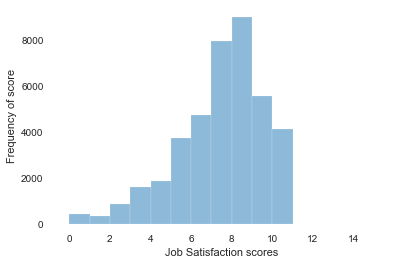

In [65]:
bin_edges = range(0, 16)
df_2017_srs.plot.hist(bins=bin_edges, alpha=0.5)
plt.xlabel('Job Satisfaction scores')
plt.ylabel('Frequency of score')
plt.show()

In [66]:
df_2018_srs = df_2018['JobSat']

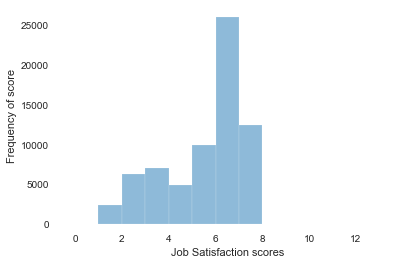

In [67]:
bin_edges = range(0, 14)
df_2018_srs.plot.hist(bins=bin_edges, alpha=0.5)
plt.xlabel('Job Satisfaction scores')
plt.ylabel('Frequency of score')
plt.show()

In [68]:
df_2019_srs = df_2019['JobSat']

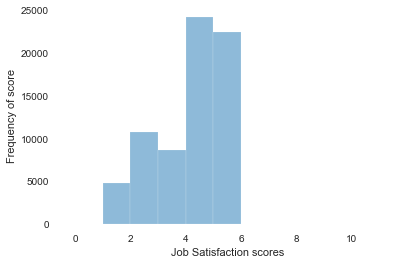

In [69]:
bin_edges = range(0, 12)
df_2019_srs.plot.hist(bins=bin_edges, alpha=0.5)
plt.xlabel('Job Satisfaction scores')
plt.ylabel('Frequency of score')
plt.show()

In [70]:
df_2020_srs = df_2020['JobSat']

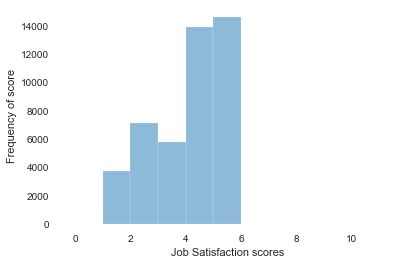

In [71]:
bin_edges = range(0, 12)
df_2020_srs.plot.hist(bins=bin_edges, alpha=0.5)
plt.xlabel('Job Satisfaction scores')
plt.ylabel('Frequency of score')
plt.show()

## yearly job satisfaction scores by country

In [72]:
def get_dict_of_dict_job_satisfaction(job_sat_scores_in):
    dict_data_dict = dict()
    dict_data_dict['Satisfied'] = job_sat_scores_in.get_high_scores()
    dict_data_dict['Neither'] =job_sat_scores_in.get_medium_scores()
    dict_data_dict['Dissatisfied'] = job_sat_scores_in.get_low_scores()
    dict_data_dict['Blank'] = job_sat_scores_in.get_blank_response()
    return dict_data_dict

In [73]:
def create_vincent_job_sat_bar_chart(df_in, countries_with_locations_srs, file_name_addendum, response_type_str):
    json_files_list = list()
    for country in countries_with_locations_srs.values:
        job_sat_scores_loc = countriesDataManager.get_job_sat_scores(country, response_type_str)
        
        dict_data_dict = get_dict_of_dict_job_satisfaction(job_sat_scores_loc)
        bar = plot_vincent_grouped_bar(dict_data_dict, 
                                       'Job Satisfaction', 
                                       'Percentage Score', 
                                       220, 
                                       250)
        
        json_file = country + '_'+ file_name_addendum + '.json'
        bar.to_json(json_file)
        json_files_list.append(json_file)
    df_copy = df_in.copy()
    df_copy['json_file'] = json_files_list
    return df_copy

In [74]:
locations_df_modified_job_sat =create_vincent_job_sat_bar_chart(locations_df, 
                                                                countries_with_locations, 
                                                                'job_sat', 
                                                                'JobSat')

In [75]:
popup_max_width = 500
global_job_sat_map = plot_map(locations_df_modified_job_sat, popup_max_width)

In [76]:
global_job_sat_map

### show yearly job satisfaction scores for selected countries

In [77]:
job_sat_scores_sweden = countriesDataManager.get_job_sat_scores('Sweden', 'JobSat')

In [78]:
dict_dict_sweden = get_dict_of_dict_job_satisfaction(job_sat_scores_sweden)

In [79]:
job_sat_bar_sweden = plot_vincent_grouped_bar(dict_dict_sweden, 
                                              'Job Satisfaction', 
                                              'Percentage Score', 
                                              220, 
                                              250)

In [80]:
job_sat_bar_sweden.display()

In [81]:
job_sat_scores_japan = countriesDataManager.get_job_sat_scores('Japan', 'JobSat')

In [82]:
dict_dict_japan = get_dict_of_dict_job_satisfaction(job_sat_scores_japan)

In [83]:
job_sat_bar_japan = plot_vincent_grouped_bar(dict_dict_japan, 
                                              'Job Satisfaction', 
                                              'Percentage Score', 
                                              220, 
                                              250)

In [84]:
job_sat_bar_japan.display()

# Top three programming languages overall

In [103]:
def get_rankings_df(top_n_yearly_ranking):
    langauages_dat_list = []
    index_list = []
    for language in top_n_yearly_ranking.get_first_sorted_n_rankings_by_languages().keys():
        year_rankings_data = top_n_yearly_ranking[language]
        langauages_dat_list.append(year_rankings_data)
        index_list.append(language)
    lang_ranking_df = pd.DataFrame(langauages_dat_list, index=index_list)
    return lang_ranking_df

In [86]:
languageRanking = LanguageRanking()

In [108]:
for year in ['2017', '2018', '2019', '2020']:
    languageRanking.set_rankings(df_2017, year)

top_3_yearly_dict = languageRanking.get_first_sorted_n_rankings_by_languages()

In [110]:
top_3_yearly_bar = plot_vincent_grouped_bar(top_3_yearly_dict, 
                                            'Top Languages', 
                                            'Percentage Scores', 
                                            380, 
                                            250)

In [111]:
top_3_yearly_bar.display()

## top three programming languages by country

In [112]:
def create_vincent_language_rankings_bar_chart(df_in, countries_with_locations_srs, file_name_addendum, response_type_str):
    json_files_list = list()
    for country in countries_with_locations_srs.values:
        languageYearlyRankings_loc = countriesDataManager.get_yearly_language_rankings(country, response_type_str)
        
        top_3_yearly_dict_loc = languageYearlyRankings_loc.get_first_sorted_n_rankings_by_languages()
        top_3_yearly_bar_loc = plot_vincent_grouped_bar(top_3_yearly_dict_loc, 
                                                        'Top Languages', 
                                                        'Percentage Scores', 
                                                        380, 
                                                        250)
        
        json_file = country + '_'+ file_name_addendum + '.json'
        top_3_yearly_bar_loc.to_json(json_file)
        json_files_list.append(json_file)  
    df_copy = df_in.copy()
    df_copy['json_file'] = json_files_list
    return df_copy

In [113]:
locations_df_modified_lang_ranking = create_vincent_language_rankings_bar_chart(locations_df, 
                                                                                countries_with_locations, 
                                                                                'lang_ranking', 
                                                                                'lang_ranking')

In [114]:
popup_max_width = 500
child_width=500
global_lang_ranking_map = plot_map(locations_df_modified_lang_ranking, popup_max_width, child_width)

In [115]:
global_lang_ranking_map

In [128]:
save_map_as_image(global_lang_ranking_map, 'global_lang_ranking_map')

### show top three programming languages for selected countries

In [116]:
languageYearlyRankings = countriesDataManager.get_yearly_language_rankings('Sweden', 'lang_ranking')

In [117]:
top_3_yearly_dict_sweden = languageYearlyRankings.get_first_sorted_n_rankings_by_languages()

In [118]:
top_3_yearly_bar_sweden = plot_vincent_grouped_bar(top_3_yearly_dict_sweden, 
                                                   'Top Languages', 
                                                   'Percentage Scores', 
                                                   380, 
                                                   250)

In [119]:
top_3_yearly_bar_sweden.display()

In [121]:
languageYearlyRankings_usa = countriesDataManager.get_yearly_language_rankings('United States', 'lang_ranking')

In [122]:
top_3_yearly_dict_usa = languageYearlyRankings_usa.get_first_sorted_n_rankings_by_languages()

In [126]:
top_3_yearly_bar_usa = plot_vincent_grouped_bar(top_3_yearly_dict_usa, 
                                                'Top Languages', 
                                                'Percentage Scores', 
                                                380, 
                                                250)

In [127]:
top_3_yearly_bar_usa.display()